In [19]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Setup Project Root
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 2. Core Imports
from src.dataloader.DataLoader import DataLoader
from src.datawrapper.DataWrapper import DataWrapper
from src.transformer.TechIndicGenerator import TechIndicGenerator
from src.transformer.DataSelector import DataSelector
from src.transformer.Scope import ScopeShifter

# 3. Model Imports (Linear Regression)
from sklearn.linear_model import Ridge
from src.model.ScikitModel import ScikitModel
from src.learner.Trainer import Trainer
from src.learner.Tester import Tester
from src.learner.Learner import UpdatingLearner

# 4. Optimization & Evaluation Imports
from src.optimizer.Optimizer import Optimizer
from src.utils.Evaluation import Metric
# Ensure SignBasedStrategy is available in your Simulation.py as discussed
from src.simulation.Simulation import SignBasedStrategy

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
print("--- Loading Data ---")
csv_path = PROJECT_ROOT / 'btc_usdt_1h.csv'
wrapper = DataLoader.load_wrap(str(csv_path), data_type='tick')

# 1. Generate Features (Technical Indicators)
print("Generating Technical Indicators...")
gen = TechIndicGenerator()
gen.compute_RSI(wrapper, period=14)
gen.compute_ATR(wrapper, period=14)
gen.compute_BBANDS(wrapper, period=20)
gen.compute_EMA(wrapper, period=9)
gen.compute_KAMA(wrapper, period=10)

# 2. Compute Target (Next Period Log Return)
# The model will predict the MAGNITUDE and DIRECTION of the return
wrapper.compute_log_return()

print(f"Data Ready: {wrapper.get_dataframe().shape}")
print(f"Columns: {wrapper.get_feature_columns()}")

--- Loading Data ---
Generating Technical Indicators...
Data Ready: (8739, 14)
Columns: ['bb_lower', 'ema', 'rsi', 'open', 'atr', 'kama', 'high', 'close', 'bb_middle', 'bb_upper', 'volume', 'low']


In [21]:
# 1. Define Rolling Window Logic
# Train on 30 days, Test on next 24 hours, Shift by 24 hours
train_scope = ScopeShifter(
    wrapper=wrapper, 
    parameters={'window_size': "30d", 'step_size': "24h"}
)

selector = DataSelector(
    wrapper=wrapper, 
    training_scope=train_scope,
    test_parameters={'testing_window_size': "24h"}
)

# 2. Initialize Linear Model (Ridge Regression)
# We use Ridge instead of 'LinearRegression' to allow alpha optimization.
# (alpha=1.0 is default, we will optimize this)
ridge_model = Ridge(random_state=42) 
model = ScikitModel(ridge_model)

# 3. Define Input/Output Columns
# Explicitly tell the model what to use
model.input_columns = wrapper.get_feature_columns()
wrapper.data_handler.label_cols = ['log_return']

from src.transformer.FeatureScaler import FeatureScaler

# 1. Create the Scaler
scaler = FeatureScaler(method='standard') 
# Note: You can specify columns=['rsi', 'volume'] if you only want to scale specific features.

# 2. Inject Scaler into Trainer and Tester
# Important: They must share the SAME scaler object so Tester knows the Train statistics.
trainer = Trainer(model=model, feature_scaler=scaler)
tester = Tester(model=model, feature_scaler=scaler)

learner = UpdatingLearner(
    trainer=trainer,
    tester=tester,
    data_wrapper=wrapper,
    data_selector=selector
)

[WindowScope] Initialized with start: 2024-12-17 17:00:00, end: 2025-12-16 19:00:00, step_size: 1 days 00:00:00, window_size: 30 days 00:00:00
[WindowScope] Initialized with start: 2024-12-17 17:00:00, end: 2025-12-16 19:00:00, step_size: 1 days 00:00:00, window_size: 30 days 00:00:00


In [22]:
result = learner.compute()

In [23]:
sum(result.get_dataframe()['prediction'] < 0)

3945

In [24]:
# --- Cell 4 Update ---

from src.simulation.Simulation import ProportionalStrategy

# 1. Use Log Uniform Distribution
# This lets Optuna search 0.01, 0.1, 1, 10, 100 equally, breaking out of plateaus.
search_space = {
    'alpha': ('float', 1e-2, 1e+2, {'log': True}) 
}

# 2. Optimize using Proportional Strategy
# This ensures every tiny change in alpha changes the Sharpe Ratio.
optimizer = Optimizer(
    wrapper=wrapper,
    learner=learner,
    metric=Metric.SHARPE_RATIO, 
    search_space=search_space,
    simulation_class=SignBasedStrategy, # <--- KEY CHANGE
    n_trials=20, 
    direction="maximize"
)

print("--- Starting Optimization (Magnitude Sensitive) ---")
optimizer.run()

[I 2026-01-24 01:07:26,647] A new study created in memory with name: no-name-c33e18ed-4455-4979-a0d5-1f12152fb8ce


--- Starting Optimization (Magnitude Sensitive) ---


[I 2026-01-24 01:07:31,623] Trial 0 finished with value: 0.07109572029491061 and parameters: {'alpha': 18.062187649434957}. Best is trial 0 with value: 0.07109572029491061.


Trial 0: sharpe_ratio = 0.0711


[I 2026-01-24 01:07:36,424] Trial 1 finished with value: -0.09806016477319382 and parameters: {'alpha': 0.05105988944993477}. Best is trial 0 with value: 0.07109572029491061.


Trial 1: sharpe_ratio = -0.0981


[I 2026-01-24 01:07:41,242] Trial 2 finished with value: 0.09039285522396645 and parameters: {'alpha': 10.591627454933448}. Best is trial 2 with value: 0.09039285522396645.


Trial 2: sharpe_ratio = 0.0904


[I 2026-01-24 01:07:46,055] Trial 3 finished with value: 0.0529997875143104 and parameters: {'alpha': 9.685814171313284}. Best is trial 2 with value: 0.09039285522396645.


Trial 3: sharpe_ratio = 0.0530


[I 2026-01-24 01:07:50,923] Trial 4 finished with value: -0.1465580550012669 and parameters: {'alpha': 1.305699362752345}. Best is trial 2 with value: 0.09039285522396645.


Trial 4: sharpe_ratio = -0.1466


[I 2026-01-24 01:07:55,754] Trial 5 finished with value: -0.11594246684874074 and parameters: {'alpha': 0.8291773270943747}. Best is trial 2 with value: 0.09039285522396645.


Trial 5: sharpe_ratio = -0.1159


[I 2026-01-24 01:08:00,598] Trial 6 finished with value: -0.17233243857458483 and parameters: {'alpha': 0.1790627819428999}. Best is trial 2 with value: 0.09039285522396645.


Trial 6: sharpe_ratio = -0.1723


[I 2026-01-24 01:08:05,420] Trial 7 finished with value: -0.08699786487971263 and parameters: {'alpha': 52.20049341377068}. Best is trial 2 with value: 0.09039285522396645.


Trial 7: sharpe_ratio = -0.0870


[I 2026-01-24 01:08:10,177] Trial 8 finished with value: -0.11766543672023984 and parameters: {'alpha': 2.9500772282811987}. Best is trial 2 with value: 0.09039285522396645.


Trial 8: sharpe_ratio = -0.1177


[I 2026-01-24 01:08:15,027] Trial 9 finished with value: -0.14473982472082908 and parameters: {'alpha': 0.23337121557878324}. Best is trial 2 with value: 0.09039285522396645.


Trial 9: sharpe_ratio = -0.1447


[I 2026-01-24 01:08:20,204] Trial 10 finished with value: -0.16220265540664452 and parameters: {'alpha': 83.9005125959491}. Best is trial 2 with value: 0.09039285522396645.


Trial 10: sharpe_ratio = -0.1622


[I 2026-01-24 01:08:25,127] Trial 11 finished with value: 0.06954586620448437 and parameters: {'alpha': 12.438045820956779}. Best is trial 2 with value: 0.09039285522396645.


Trial 11: sharpe_ratio = 0.0695


[I 2026-01-24 01:08:30,137] Trial 12 finished with value: 0.06390816185402233 and parameters: {'alpha': 13.710674125203079}. Best is trial 2 with value: 0.09039285522396645.


Trial 12: sharpe_ratio = 0.0639


[I 2026-01-24 01:08:34,836] Trial 13 finished with value: -0.09182801021083122 and parameters: {'alpha': 5.563567531182994}. Best is trial 2 with value: 0.09039285522396645.


Trial 13: sharpe_ratio = -0.0918


[I 2026-01-24 01:08:39,634] Trial 14 finished with value: -0.04586768886386576 and parameters: {'alpha': 33.06160926410327}. Best is trial 2 with value: 0.09039285522396645.


Trial 14: sharpe_ratio = -0.0459


[I 2026-01-24 01:08:44,285] Trial 15 finished with value: -0.12990469686083483 and parameters: {'alpha': 1.9261465620621137}. Best is trial 2 with value: 0.09039285522396645.


Trial 15: sharpe_ratio = -0.1299


[I 2026-01-24 01:08:48,894] Trial 16 finished with value: -0.006733746764223662 and parameters: {'alpha': 26.227883374879372}. Best is trial 2 with value: 0.09039285522396645.


Trial 16: sharpe_ratio = -0.0067


[I 2026-01-24 01:08:53,524] Trial 17 finished with value: -0.06673643593114585 and parameters: {'alpha': 0.015412719751874448}. Best is trial 2 with value: 0.09039285522396645.


Trial 17: sharpe_ratio = -0.0667


[I 2026-01-24 01:08:58,273] Trial 18 finished with value: -0.15463324072109247 and parameters: {'alpha': 0.5698093742117764}. Best is trial 2 with value: 0.09039285522396645.


Trial 18: sharpe_ratio = -0.1546


[I 2026-01-24 01:09:03,102] Trial 19 finished with value: -0.095370460342967 and parameters: {'alpha': 4.662249093706733}. Best is trial 2 with value: 0.09039285522396645.


Trial 19: sharpe_ratio = -0.0954


In [25]:
print(f"Best Alpha: {optimizer.best_params}")
print(f"Best Sharpe Ratio: {optimizer.best_value:.4f}")

Best Alpha: {'alpha': 10.591627454933448}
Best Sharpe Ratio: 0.0904


Running final simulation with optimal parameters...
Total Return: 20.79%


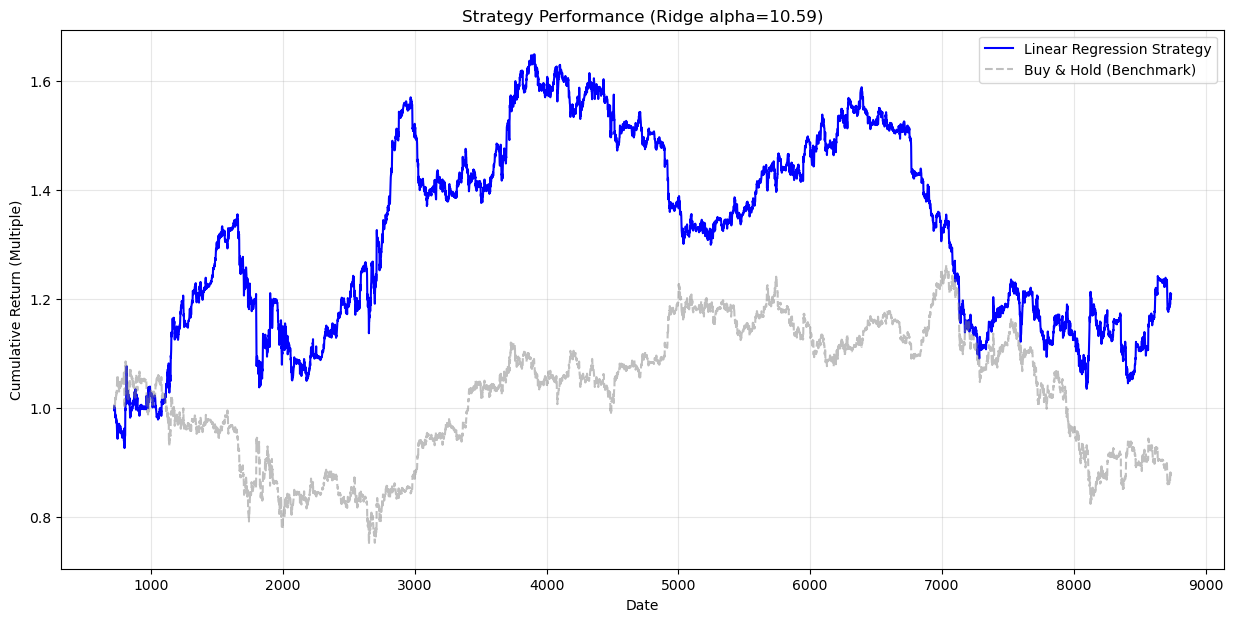

In [26]:
# 1. Apply Best Parameters
learner.set_model_params(optimizer.best_params)

# 2. Run Full Walk-Forward Validation
print("Running final simulation with optimal parameters...")
final_wrapper = learner.compute()
results_df = final_wrapper.get_dataframe()

# 3. Evaluate Strategy
# We manually run the simulation to get the returns series for plotting
sim = SignBasedStrategy(final_wrapper)
strategy_returns = sim.calculate_returns(results_df['prediction'])

# 4. Calculate Final Metrics
# Accumulate returns for equity curve
equity_curve = np.exp(strategy_returns.cumsum())
benchmark_curve = np.exp(results_df['log_return'].cumsum())

# Metrics Summary
total_return = equity_curve.iloc[-1] - 1
print(f"Total Return: {total_return * 100:.2f}%")

# 5. Plotting
plt.figure(figsize=(15, 7))
plt.plot(equity_curve, label='Linear Regression Strategy', color='blue')
plt.plot(benchmark_curve, label='Buy & Hold (Benchmark)', color='gray', linestyle='--', alpha=0.5)

plt.title(f"Strategy Performance (Ridge alpha={optimizer.best_params.get('alpha'):.2f})")
plt.ylabel("Cumulative Return (Multiple)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# sim = SignBasedStrategy(wrapper)
# returns = sim.calculate_returns(result.get_dataframe()['prediction'])

In [28]:
# for i in returns:
#     print(i*100)

In [29]:
# # 1. Setup
# from sklearn.linear_model import Ridge
# from src.model.ScikitModel import ScikitModel
# from src.simulation.Simulation import SignBasedStrategy

# # 2. Run with Alpha = 1.0
# print("--- Test Run 1 (Alpha=1.0) ---")
# model = ScikitModel(Ridge(alpha=1.0, random_state=42))
# # Update your learner/trainer to use this NEW model
# learner.trainer.model = model 
# learner.tester.model = model
# # Train & Predict
# res1 = learner.compute()
# preds1 = res1.get_dataframe()['prediction']
# sim1 = SignBasedStrategy(wrapper)
# rets1 = sim1.calculate_returns(preds1)
# print(f"Sum of Returns (Alpha 1.0): {rets1.sum():.6f}")

# # 3. Run with Alpha = 1000.0 (Huge regularization to force a change)
# print("\n--- Test Run 2 (Alpha=1000.0) ---")
# model2 = ScikitModel(Ridge(alpha=1000.0, random_state=42))
# learner.trainer.model = model2
# learner.tester.model = model2
# # Train & Predict
# res2 = learner.compute()
# preds2 = res2.get_dataframe()['prediction']
# sim2 = SignBasedStrategy(wrapper)
# rets2 = sim2.calculate_returns(preds2)
# print(f"Sum of Returns (Alpha 1000): {rets2.sum():.6f}")

# # 4. Compare
# diff = (preds1 - preds2).abs().sum()
# print(f"\nDifference in Raw Predictions: {diff:.6f}")

# if rets1.equals(rets2):
#     print("❌ CONCLUSION: Strategy Returns are IDENTICAL. Optimization will fail.")
#     if diff == 0:
#         print("   -> Cause: Model predictions are identical. Parameters are NOT updating.")
#     else:
#         print("   -> Cause: Predictions change, but Signs do not. Use ProportionalStrategy.")
# else:
#     print("✅ CONCLUSION: Strategy Returns are DIFFERENT. Optimization should work.")